In [ ]:
from utils import *

NOTEBOOK_ID = '01'
RUN_PREPROCESS = False
RUN_MODELS = False

/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0


In [ ]:
hummel_df = pd.read_csv(f'{DATASET_DIR}/01-hummel/all_acts_with_empty_hummel.csv').rename(columns={'ArrayDNA':'DNAseq'})
target_cols = [col for col in hummel_df.columns if 'Activity_' in col]

# preprocess dataset

In [ ]:
if RUN_PREPROCESS:
    for target_col in target_cols:
        tmp_df = preprocess_dataset(hummel_df,target_col,keep=False)
        tmp_df.to_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_{target_col}.csv',index=False)

# train/test targets

In [ ]:
if RUN_MODELS:
    for target_col in target_cols:
        tmp_df = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_{target_col}.csv')
        X = np.asarray([[AA_TO_I[aa] for aa in x] for x in tmp_df['AAseq']])
        y = tmp_df[target_col].to_numpy()
        threshold = tmp_df[target_col].median()
        for scaler in ['standard','minmax','both']:
            dataset, idx = split_dataset(X,y,threshold,scaler=scaler)
            train_ADhunter(dataset,out_dir=f'{TARGET_DIR}/02-evaluate',out_name=f'hummel_{target_col}_{scaler}',version='v1',random_state=1)
            test_ADhunter(dataset,out_dir=f'{TARGET_DIR}/02-evaluate',out_name=f'hummel_{target_col}_{scaler}',version='v1',random_state=1)

# evaluation targets

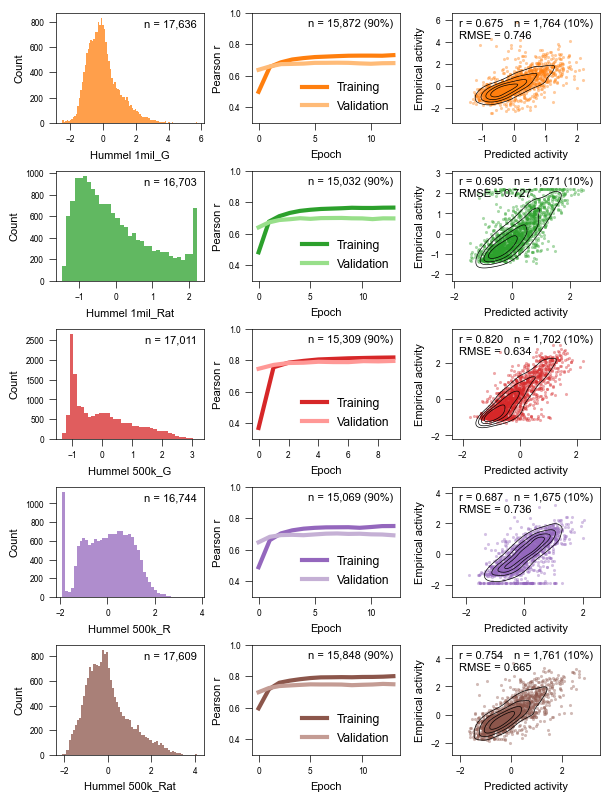

In [7]:
fig = plt.figure(figsize=(6,9),constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=6, figure=fig)

for i, target_col in enumerate(target_cols):
    tmp_df = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_{target_col}.csv')
    tmp_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform(tmp_df[target_col].to_numpy().reshape(-1,1))

    ax0 = fig.add_subplot(gs[i,0])
    ax1 = fig.add_subplot(gs[i,1])
    ax2 = fig.add_subplot(gs[i,2])
    train_df = pd.read_pickle(f'{TARGET_DIR}/02-evaluate/03-results/ADhunter_v1-hummel_{target_col}_standard_state1_train_df.pkl')
    test_df = pd.read_pickle(f'{TARGET_DIR}/02-evaluate/03-results/ADhunter_v1-hummel_{target_col}_standard_state1_test_df.pkl')

    n_total = len(tmp_df)
    n_test = len(test_df)
    n_train = n_total - n_test
    color1_idx, color2_idx = COLOR_PAIRS[i]
    color1, color2 = COLORS[color1_idx], COLORS[color2_idx]
    g = sns.histplot(data=tmp_df,x='activity_scaled',ax=ax0,color=color1,element='step',edgecolor=None)
    g.set(xlabel='Hummel '+target_col.replace('Activity_',''))
    ax0.text(0.95,0.95,ha='right',va='top',s=f'n = {format(n_total,",")}',transform=ax0.transAxes)
    
    plot_train_val(train_df,ax1,color1,color2)
    ax1.text(0.95, 0.95, ha='right',va='top',s =f'n = {int(n_train):,d} ({(n_train/n_total)*100:.0f}%)',transform=ax1.transAxes)

    pearson_corr = plot_test(test_df, ax2, color1)
    r2 = r2_score(test_df['y_test_hat'],test_df['y_test'])
    rmse = mean_squared_error(test_df['y_test_hat'],test_df['y_test'],squared=False)
    ax2.text(0.95, 0.95, ha='right',va='top',s =f'n = {int(n_test):,d} ({(n_test/n_total)*100:.0f}%)',transform=ax2.transAxes)
    ax2.text(0.05, 0.95, ha='left',va='top',s =f'r = {pearson_corr:.3f}\nRMSE = {rmse:.3f}',transform=ax2.transAxes)

    del train_df, test_df, tmp_df

if SAVE_FIGURES:
    fig.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-hummel_target_comparison.png',dpi=400,transparent=False,bbox_inches='tight')

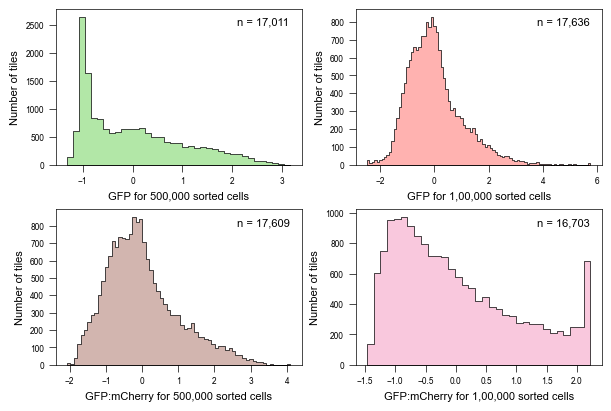

In [8]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(6,4),constrained_layout=True)

target_col = 'Activity_500k_G'
tmp_df = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_{target_col}.csv')
tmp_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform(tmp_df[target_col].to_numpy().reshape(-1,1))
n_total = len(tmp_df)
g = sns.histplot(data=tmp_df,x='activity_scaled',ax=axes[0,0],color=COLORS[5],element='step',edgecolor='black',linewidth=0.5)
g.set(xlabel='GFP for 500,000 sorted cells',ylabel='Number of tiles')
axes[0,0].text(0.95,0.95,ha='right',va='top',s=f'n = {format(n_total,",")}',transform=axes[0,0].transAxes)

target_col = 'Activity_1mil_G'
tmp_df = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_{target_col}.csv')
tmp_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform(tmp_df[target_col].to_numpy().reshape(-1,1))
n_total = len(tmp_df)
g = sns.histplot(data=tmp_df,x='activity_scaled',ax=axes[0,1],color=COLORS[7],element='step',edgecolor='black',linewidth=0.5)
g.set(xlabel='GFP for 1,00,000 sorted cells',ylabel='Number of tiles')
axes[0,1].text(0.95,0.95,ha='right',va='top',s=f'n = {format(n_total,",")}',transform=axes[0,1].transAxes)

target_col = 'Activity_500k_Rat'
tmp_df = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_{target_col}.csv')
tmp_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform(tmp_df[target_col].to_numpy().reshape(-1,1))
n_total = len(tmp_df)
g = sns.histplot(data=tmp_df,x='activity_scaled',ax=axes[1,0],color=COLORS[11],element='step',edgecolor='black',linewidth=0.5)
g.set(xlabel='GFP:mCherry for 500,000 sorted cells',ylabel='Number of tiles')
axes[1,0].text(0.95,0.95,ha='right',va='top',s=f'n = {format(n_total,",")}',transform=axes[1,0].transAxes)

target_col = 'Activity_1mil_Rat'
tmp_df = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_{target_col}.csv')
tmp_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform(tmp_df[target_col].to_numpy().reshape(-1,1))
n_total = len(tmp_df)
g = sns.histplot(data=tmp_df,x='activity_scaled',ax=axes[1,1],color=COLORS[13],element='step',edgecolor='black',linewidth=0.5)
g.set(xlabel='GFP:mCherry for 1,00,000 sorted cells',ylabel='Number of tiles')
axes[1,1].text(0.95,0.95,ha='right',va='top',s=f'n = {format(n_total,",")}',transform=axes[1,1].transAxes)
if SAVE_FIGURES:
    fig.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-hummel_target_comparison.png',dpi=400,transparent=False,bbox_inches='tight')